In [1]:
from itertools import islice

import matplotlib.pyplot as plt
import networkx as nx
from networkx.classes.function import path_weight
import numpy as np
import tqdm
from scipy.optimize import curve_fit

from networkx.generators.harary_graph import hkn_harary_graph
import h5py

In [2]:
def path_to_bit_rep(p, G):
    p = [(v, p[i+1]) for i, v in enumerate(p[:-1])]
    
    bit_rep = []
    for e in G.edges():
        if (e[0], e[1]) in p:
            bit_rep.append(1)
        else:
            bit_rep.append(0)
    
    return np.array(bit_rep)


def compute_dH(p0, p1, G):
    p0 = path_to_bit_rep(p0, G)
    p1 = path_to_bit_rep(p1, G)
    
    return np.abs(p0 - p1).sum()


def sp(G, source, target):
    G = nx.DiGraph(G)
    
    np.random.seed()
    W = np.random.randn(G.number_of_edges()) / 6 + 0.5
    W[W < 0] = 0
    W[W > 1] = 1
    for i, e in enumerate(G.edges()):
        G[e[0]][e[1]]['weight'] = W[i]

    p0, p1 = list(islice(nx.shortest_simple_paths(G, source, target, weight="weight"), 2))
    delta = path_weight(G, p1, weight="weight") - path_weight(G, p0, weight="weight")

    return delta

24


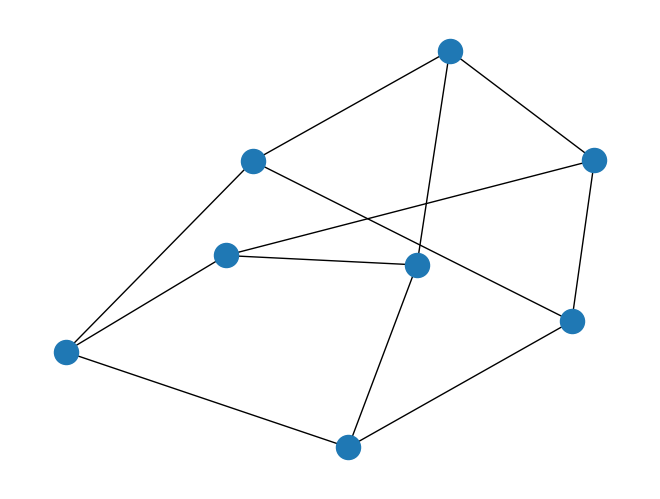

In [3]:
G = hkn_harary_graph(3, 8)
print(G.number_of_edges()*2)
nx.draw(G)

In [5]:
to_graph = False
if to_graph:
    for n in range(4, 31):
        G = hkn_harary_graph(3, n)
        longest = (0, 0, 0)
        paths = nx.shortest_path(G)
        for s in G.nodes:
            for t in G.nodes:
                if len(paths[s][t]) > longest[2]:
                    longest = (s, t, len(paths[s][t]))
    
        Ad = nx.adjacency_matrix(G).todense()
        with h5py.File(f"data/harary/graph_n={n}.jld", "w") as hf:
            hf.create_dataset("Ad", data=Ad)
            hf.create_dataset("source", data=longest[0]+1)
            hf.create_dataset("target", data=longest[1]+1)

In [6]:
to_compute = False
if to_compute:
    M = 10000
    n_max = 30

    df = np.zeros((n_max+1-4, 2))
    for n in range(4, n_max+1):
        G = hkn_harary_graph(3, n)
        f = h5py.File(f"data/graph_n={n}.jld", "r")
        source = int(np.array(f["source"]))-1
        target = int(np.array(f["target"]))-1
        
        dfM = np.zeros(M)
        for m in tqdm.tqdm(range(M)):
            dfM[m] = sp(G, source, target)
        df[n-4] = (dfM.mean(), dfM.std(ddof=1) / M**0.5)

    np.save("data/harary/deltaF.npy", df)
    
delta_f = np.load("data/harary/deltaF.npy")

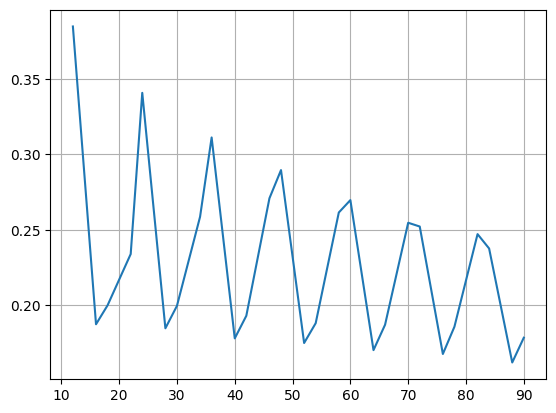

In [7]:
n_max = 30
N = np.zeros(n_max+1 - 4)
for n in range(4, n_max+1):
    G = hkn_harary_graph(3, n)
    N[n-4] = G.number_of_edges()*2
    
plt.plot(N, delta_f[:, 0])
plt.grid()

In [9]:
sc = np.zeros((8, 2))
dmin = np.zeros((8, 2))

n_max = 8
for n in range(4, n_max+1):
    f = h5py.File(f"data/harary/A=N/n={n}.jld", "r")
    scM, dminM = np.array(f["scM"]), np.array(f["dminM"])
    
    M = scM.shape[0]
    print(M)
    if M == 0:
        continue

    sc[n-4] = np.mean(scM), np.std(scM, ddof=1) / np.sqrt(M)
    dmin[n-4] = np.mean(dminM), np.std(dminM, ddof=1) / np.sqrt(M)

10000
10000
10000
2500
2500


In [10]:
N = np.zeros(12)
for n in range(4, 16):
    G = hkn_harary_graph(3, n)
    N[n-4] = G.number_of_edges()*2

delta_f = delta_f[:12, :]

B = 1
A = N.copy()

first_order = np.zeros(delta_f.shape)
first_order[:, 0] = 2 * B*delta_f[:, 0] / (B*delta_f[:, 0] + A+2)
first_order[:, 1] = 2*(A+2) / (B*delta_f[:, 0] + A+2)**2 * B*delta_f[:, 1]

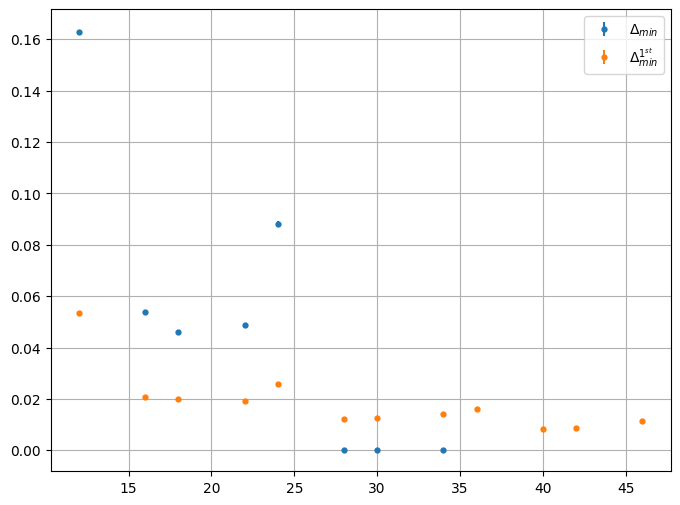

In [11]:
f_fit = lambda x, a, b, c, d: a / x**b + c / x**d

plt.figure(figsize=(8, 6))
plt.errorbar(N[:8], dmin[:, 0], yerr=dmin[:, 1], fmt=".", ms=7, label="$\Delta_{min}$")
plt.errorbar(N, first_order[:, 0], yerr=first_order[:, 1], fmt=".", ms=7, label="$\Delta_{min}^{1^{st}}$")
# plt.errorbar(N, delta_f[:, 0] / delta_f[0, 0], yerr=delta_f[:, 1], fmt=".", ms=7, label="$\Delta_f$")

# x = np.linspace(N[0], N[-1], 1000)
# popt, pcov = curve_fit(f_fit, N[:5], dmin[:5, 0], sigma=dmin[:5, 1], 
#                        p0=[0.1, 0.1, 1, 1], bounds=([0, 1, 0, 0.1], [np.inf, np.inf, np.inf, np.inf]))
# plt.plot(x, f_fit(x, *popt))
# print(popt)

# x = np.linspace(N[0], N[-1], 1000)
# popt, pcov = curve_fit(f_fit, N, first_order[:, 0], sigma=first_order[:, 1], p0=[0.1, 1, 0.05, 0], maxfev=10000, 
#                        bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
# plt.plot(x, f_fit(x, *popt))
# print(popt)

plt.legend()
plt.grid()

2.244237816100677 0.6735527710014356 3.682534287065803e-19


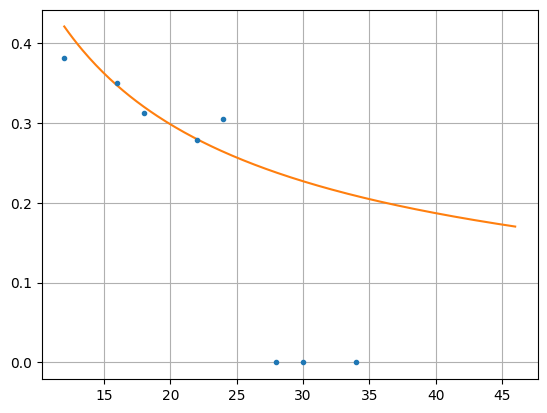

In [12]:
f_fit = lambda x, a, b, c: a / (x**b + c)

plt.errorbar(N[:8], sc[:, 0], fmt='.', yerr=sc[:, 1])
x = np.linspace(N[0], N[-1], 200)
popt, pcov = curve_fit(f_fit, N[1:5], sc[1:5, 0], sigma=sc[1:5, 1], 
                       p0=[0.1, 1, 1], bounds=[(0, 0, 0), (np.inf, np.inf, np.inf)])
print(*popt)
plt.plot(x, f_fit(x, *popt))

plt.grid()